In [26]:
import json
from glob import glob

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()


class DSet(Dataset):

    def __init__(self, samples, step=100):
        self.data = np.zeros((len(samples), step, 4), dtype=np.float32)
        self.target = np.zeros(len(samples), dtype=np.float32)
        raw_data = np.load('data/prop_graph.npz')
        for i, sample in enumerate(samples):
            span = raw_data[sample][:, 0]
            for t, lx, ly, x, y in raw_data[sample]:
                if ly > 5: continue
                tid = int(np.log10(t + 1) * step / 8.1)
                self.data[i][tid][ly-2] += 1
            if 'rumor' in sample:
                self.target[i] = 1

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


class CNN(nn.Module):

    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, (7, 2), padding=(3, 0))
        self.conv2 = nn.Conv2d(8, 16, 3, padding=(1, 0))
        self.fc1 = nn.Linear(input_size // 4 * 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.view(x.size(0), 1, x.size(1), x.size(2))
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=(2, 1), stride=(2, 1)))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=(2, 1), stride=(2, 1)))
        x = F.dropout(x.view(x.size(0), -1), training=self.training)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)


class RNN(nn.Module):

    def __init__(self, input_size, hidden_size=64, bidirectional=True):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_directions = 2 if bidirectional else 1
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.n_directions, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1, self.input_size)
        h0 = self._init_hidden_state(x.size(0))
        x, hn = self.rnn(x, h0)
        x = self.fc(x[:, -1, :])
        return F.sigmoid(x)

    def _init_hidden_state(self, batch_size):
        h0 = torch.zeros(self.n_directions, batch_size, self.hidden_size)
        if use_cuda:
            h0 = h0.cuda()
        return Variable(h0)


class CombinedNet(nn.Module):

    def __init__(self, cnn_input_size, rnn_input_size, hidden_size=64):
        super(CombinedNet, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_input_size = rnn_input_size
        self.rnn = nn.GRU(rnn_input_size, hidden_size, batch_first=True, bidirectional=True, dropout=0.5)
        self.conv1 = nn.Conv2d(1, 8, (3, 2), padding=(1, 0))
        self.conv2 = nn.Conv2d(8, 16, 3, padding=(1, 0))
        self.fc_dim = cnn_input_size // 4 * 16 + hidden_size * 2
        self.fc = nn.Linear(self.fc_dim, 1)

    def forward(self, x):
        rx = x.view(x.size(0), -1, self.rnn_input_size)
        cx = x.view(x.size(0), 1, x.size(1), x.size(2))
        h0 = self._init_hidden_state(rx.size(0))
        rx, hn = self.rnn(rx, h0)
        cx = F.relu(F.max_pool2d(self.conv1(cx), kernel_size=(2, 1), stride=(2, 1)))
        cx = F.relu(F.max_pool2d(self.conv2(cx), kernel_size=(2, 1), stride=(2, 1)))
        rcx = torch.cat((rx[:, -1, :].view(x.size(0), -1), cx.view(x.size(0), -1)), dim=1)
        out = self.fc(F.dropout(rcx, training=self.training))
        return F.sigmoid(out)

    def _init_hidden_state(self, batch_size):
        h0 = torch.zeros(2, batch_size, self.hidden_size)
        if use_cuda:
            h0 = h0.cuda()
        return Variable(h0)

In [2]:
def train(model, n_epoch=5, lr=0.05):

    if use_cuda:
        model.cuda()
    criterion = nn.BCELoss()
    optimizer = optim.RMSprop(model.parameters())
#     optimizer = optim.SGD(model.parameters(), lr=lr)

#     print(f'training {model.__class__.__name__} ...')
    acc_max = 0.0
    record = {x: list() for x in ['tr_loss', 'tr_acc', 'val_loss', 'val_acc', 'predict']}
    for epoch in range(n_epoch):
        print(f'Epoch {(epoch + 1):02d}')
        model.train()
        tr_loss, tr_acc = 0.0, 0.0
        for data, target in train_loader:
            target = target.view(target.size(0), 1)
            optimizer.zero_grad()
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            tr_loss += loss.data[0] * data.size(0)
            pred = torch.sign(output.data - 0.5).clamp(min=0)
            tr_acc += pred.eq(target.data).cpu().sum()
        tr_loss /= len(train_loader.dataset)
        tr_acc = tr_acc / len(train_loader.dataset)
        record['tr_loss'].append(tr_loss)
        record['tr_acc'].append(tr_acc)
        print(f'tr_loss {tr_loss:.6f} | tr_acc {tr_acc*100:.2f}%')

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        record['predict'] = []
        for data, target in test_loader:
            target = target.view(target.size(0), 1)
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.data[0] * data.size(0)
            pred = torch.sign(output.data - 0.5).clamp(min=0)
            val_acc += pred.eq(target.data).cpu().sum()
            record['predict'].append(output.data.numpy())
        val_loss /= len(test_loader.dataset)
        val_acc = val_acc / len(test_loader.dataset)
        record['val_loss'].append(val_loss)
        record['val_acc'].append(val_acc)
        print(f'val_loss {val_loss:.6f} | val_acc {val_acc*100:.2f}%')
        if record['val_acc'][-1] > acc_max:
            acc_max = record['val_acc'][-1]
            record['final'] = np.vstack(record['predict']).reshape(-1)
    return record

In [3]:
samples = glob('rumor/*.json') + glob('truth/*.json')
train_data, test_data = train_test_split(samples, test_size=0.2, random_state=42)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(DSet(train_data), batch_size=128, shuffle=True, **kwargs)
test_loader = DataLoader(DSet(test_data), batch_size=128, **kwargs)

In [10]:
def loss_curve(rec, name, ep=100):
    
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.xlim([1, ep])
    plt.ylim([0.0, 1.2])
#     plt.xlabel('Epoches')
#     plt.ylabel('Binary Cross Entropy Loss')
    plt.plot(range(1, 101), rec['tr_loss'], 'b--', label='Training Loss')
    plt.plot(range(1, 101), rec['val_loss'], 'r-', label='Validation Loss')
#     plt.legend(loc='upper right')
    plt.savefig(f'{name}.png', dpi=200)

In [12]:
rnnt = train(RNN(20))

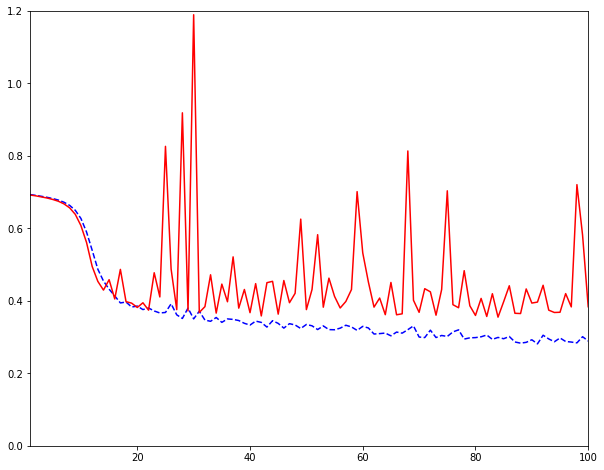

In [11]:
loss_curve(rnnt, 'rnn-top')

In [13]:
cnnt = train(CNN(100))

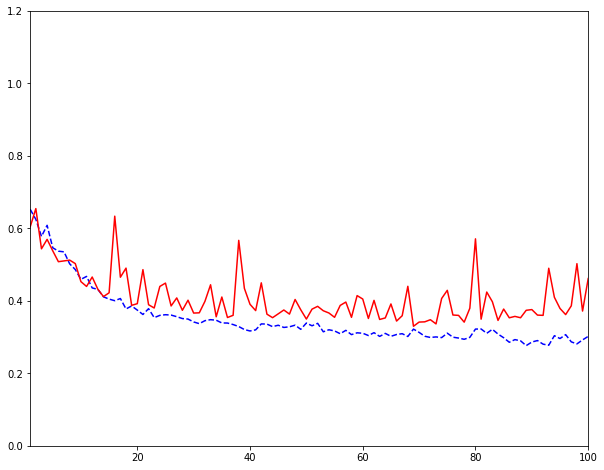

In [12]:
loss_curve(cnnt, 'cnn-top')

In [6]:
def census(output, target):

    from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

    fpr, tpr, _ = roc_curve(target, output)
    auc = roc_auc_score(target, output)
    output[output < 0.5] = 0
    output[output > 0.4] = 1
    rp = precision_score(target, output, pos_label=1)
    rr = recall_score(target, output, pos_label=1)
    rf = f1_score(target, output, pos_label=1)
    np = precision_score(target, output, pos_label=0)
    nr = recall_score(target, output, pos_label=0)
    nf = f1_score(target, output, pos_label=0)
    acc = accuracy_score(target, output)
    print(f'acc: {acc:.3f}\nrp: {rp:.3f}\nrr: {rr:.3f}\nrf: {rf:.3f}')
    print(f'np: {np:.3f}\nnr: {nr:.3f}\nnf: {nf:.3f}')
    return {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [7]:
target = []
for x, y in test_loader:
    target.append(y.numpy())

In [8]:
rnndic = census(rnnt['final'], np.hstack(target).astype(int))

acc: 0.868
rp: 0.853
rr: 0.897
rf: 0.874
np: 0.886
nr: 0.838
nf: 0.861


In [9]:
cnndic = census(cnnt['final'], np.hstack(target).astype(int))

acc: 0.874
rp: 0.878
rr: 0.874
rf: 0.876
np: 0.869
nr: 0.873
nf: 0.871


In [10]:
np.savez('data/rnnt.npz', **rnndic)
np.savez('data/cnnt.npz', **cnndic)

In [15]:
cnnt['final'].shape

(933,)

In [16]:
final = (cnnt['final'] + rnnt['final']) / 2

In [18]:
bag = census(final, np.hstack(target).astype(int))

acc: 0.877
rp: 0.862
rr: 0.904
rf: 0.882
np: 0.894
nr: 0.849
nf: 0.871


In [21]:
volume_pred = np.load('data/pred.npz')
cnnv = volume_pred['cnnv']
rnnv = volume_pred['rnnv']

In [22]:
final = (cnnt['final'] + rnnt['final'] + cnnv + rnnv) /4

In [23]:
bagall = census(final, np.hstack(target).astype(int))

acc: 0.867
rp: 0.852
rr: 0.895
rf: 0.873
np: 0.884
nr: 0.838
nf: 0.860


In [24]:
rec = []
for i in range(5):
    train_data_ = np.random.choice(train_data, len(train_data), replace=True)
    train_loader = DataLoader(DSet(train_data_), batch_size=128, shuffle=True)
    rec.append(train(RNN(20))['final'])

In [25]:
rnnfinal = np.mean(rec, axis=0)
rnntbag = census(rnnfinal, np.hstack(target).astype(int))

acc: 0.862
rp: 0.839
rr: 0.904
rf: 0.870
np: 0.890
nr: 0.818
nf: 0.853


In [26]:
rec = []
for i in range(5):
    train_data_ = np.random.choice(train_data, len(train_data), replace=True)
    train_loader = DataLoader(DSet(train_data_), batch_size=128, shuffle=True)
    rec.append(train(CNN(100))['final'])
cnnfinal = np.mean(rec, axis=0)
cnntbag = census(cnnfinal, np.hstack(target).astype(int))

acc: 0.869
rp: 0.862
rr: 0.887
rf: 0.874
np: 0.878
nr: 0.851
nf: 0.864


In [27]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42)
train_data = np.array(train_data)

In [30]:
class DSet_(Dataset):

    def __init__(self, samples, step=100):
        self.data = np.zeros((len(samples), step, 4), dtype=np.float32)
        self.target = np.zeros(len(samples), dtype=np.float32)
        raw_data = np.load('data/prop_graph.npz')
        for i, sample in enumerate(samples):
            span = raw_data[sample][:, 0]
            for t, lx, ly, x, y in raw_data[sample]:
                if ly > 5: continue
                tid = int(np.log10(t + 1) * step / 8.1)
                self.data[i][tid][ly-2] += 1
            if 'rumor' in sample:
                self.target[i] = 1
                
    def get_tensor(self):
        return torch.from_numpy(self.data)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [40]:
rnnt_stk = np.empty((len(train_data)))
rnnt_rec = []
for x, y in kf.split(train_data):
    train_loader = DataLoader(DSet(train_data[x]), batch_size=128, shuffle=True)
    val_data = DSet_(train_data[y]).get_tensor()
    model = RNN(20)
    rnnt_rec.append(train(model, n_epoch=5)['final'])
    rnnt_stk[y] = model(Variable(val_data, volatile=True)).data.numpy().reshape(-1)
rnnt_rec = np.mean(rnnt_rec, axis=0)

Epoch 01
tr_loss 0.668242 | tr_acc 63.04%
val_loss 0.504399 | val_acc 77.06%
Epoch 02
tr_loss 0.454696 | tr_acc 80.19%
val_loss 0.472137 | val_acc 78.78%
Epoch 03
tr_loss 0.372037 | tr_acc 84.22%
val_loss 0.395622 | val_acc 82.53%
Epoch 04
tr_loss 0.339915 | tr_acc 86.03%
val_loss 0.412399 | val_acc 82.85%
Epoch 05
tr_loss 0.312756 | tr_acc 87.10%
val_loss 0.365738 | val_acc 84.99%
Epoch 01
tr_loss 0.626109 | tr_acc 69.58%
val_loss 0.408294 | val_acc 83.71%
Epoch 02
tr_loss 0.416891 | tr_acc 82.04%
val_loss 0.389627 | val_acc 83.71%
Epoch 03
tr_loss 0.360727 | tr_acc 85.46%
val_loss 0.418185 | val_acc 82.74%
Epoch 04
tr_loss 0.321319 | tr_acc 86.53%
val_loss 0.380799 | val_acc 85.21%
Epoch 05
tr_loss 0.291999 | tr_acc 88.11%
val_loss 0.427305 | val_acc 83.82%
Epoch 01
tr_loss 0.666991 | tr_acc 66.26%
val_loss 0.465983 | val_acc 81.56%
Epoch 02
tr_loss 0.417740 | tr_acc 83.02%
val_loss 0.377935 | val_acc 83.92%
Epoch 03
tr_loss 0.353971 | tr_acc 85.06%
val_loss 0.360968 | val_acc 84.57%

In [44]:
cnnt_stk = np.empty((len(train_data)))
cnnt_rec = []
for x, y in kf.split(train_data):
    train_loader = DataLoader(DSet(train_data[x]), batch_size=128, shuffle=True)
    val_data = DSet_(train_data[y]).get_tensor()
    model = CNN(100)
    cnnt_rec.append(train(model, n_epoch=20)['final'])
    cnnt_stk[y] = model(Variable(val_data, volatile=True)).data.numpy().reshape(-1)
cnnt_rec = np.mean(cnnt_rec, axis=0)

Epoch 01
tr_loss 1.330521 | tr_acc 56.50%
val_loss 0.637990 | val_acc 63.56%
Epoch 02
tr_loss 0.597990 | tr_acc 74.80%
val_loss 0.541600 | val_acc 78.24%
Epoch 03
tr_loss 0.542318 | tr_acc 77.45%
val_loss 0.480242 | val_acc 80.92%
Epoch 04
tr_loss 0.458733 | tr_acc 81.57%
val_loss 0.439545 | val_acc 82.85%
Epoch 05
tr_loss 0.466476 | tr_acc 82.14%
val_loss 0.424984 | val_acc 83.82%
Epoch 06
tr_loss 0.406306 | tr_acc 83.24%
val_loss 0.468393 | val_acc 81.99%
Epoch 07
tr_loss 0.439992 | tr_acc 83.38%
val_loss 0.464486 | val_acc 81.78%
Epoch 08
tr_loss 0.405349 | tr_acc 82.98%
val_loss 0.382700 | val_acc 85.32%
Epoch 09
tr_loss 0.385909 | tr_acc 83.75%
val_loss 0.348956 | val_acc 85.32%
Epoch 10
tr_loss 0.365957 | tr_acc 85.66%
val_loss 0.363268 | val_acc 84.78%
Epoch 11
tr_loss 0.356000 | tr_acc 85.42%
val_loss 0.358141 | val_acc 86.71%
Epoch 12
tr_loss 0.373309 | tr_acc 85.32%
val_loss 0.393255 | val_acc 85.85%
Epoch 13
tr_loss 0.355574 | tr_acc 85.29%
val_loss 0.356922 | val_acc 86.39%

In [45]:
rnnt_stk, cnnt_stk

(array([0.09397812, 0.83876836, 0.79149699, ..., 0.15893215, 0.40233248,
        0.97809851]),
 array([0.22265521, 0.96149021, 0.98356426, ..., 0.30155307, 0.77231443,
        0.93409258]))

In [46]:
vpred = np.load('data/stkv.npz')
rnnv_stk = vpred['rnnv']
cnnv_stk = vpred['cnnv']
rnnv_rec = vpred['rnnr']
cnnv_rec = vpred['cnnr']

In [47]:
len(rnnv_stk), len(cnnv_stk), len(rnnt_stk), len(cnnt_stk)

(3731, 3731, 3731, 3731)

In [51]:
xstk_tr = np.vstack([rnnv_stk, cnnv_stk, rnnt_stk, cnnt_stk]).reshape(4, -1).transpose(1, 0)

In [52]:
xstk_tr.shape

(3731, 4)

In [50]:
len(rnnv_rec), len(cnnv_rec), len(rnnt_rec), len(cnnt_rec)

(933, 933, 933, 933)

In [54]:
xstk_test = np.vstack([rnnv_rec, cnnv_rec, rnnt_rec, cnnt_rec]).reshape(4, -1).transpose(1, 0)
xstk_test.shape

(933, 4)

In [59]:
y_tr = list(map(lambda x: int(x[0] == 'r'), train_data))

In [60]:
y_test = list(map(lambda x: int(x[0] == 'r'), test_data))

In [63]:
len(y_tr), len(y_test)

(3731, 933)

In [62]:
from sklearn.linear_model import LogisticRegression

In [64]:
clf = LogisticRegression()
clf.fit(xstk_tr, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
clf.score(xstk_tr, y_tr)

0.8665237201822568

In [66]:
clf.score(xstk_test, y_test)

0.8638799571275455

In [67]:
from sklearn.svm import SVC

In [68]:
clf = SVC()
clf.fit(xstk_tr, y_tr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [69]:
clf = LogisticRegression()
clf.fit(xstk_tr, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [71]:
clf = SVC()
clf.fit(xstk_tr, y_tr)
print(clf.score(xstk_tr, y_tr))
print(clf.score(xstk_test, y_test))

0.8649155722326454
0.8628081457663451


In [72]:
clf = LogisticRegression()
clf.fit(xstk_tr, y_tr)
y = clf.predict_proba(xstk_test)

In [78]:
census(y[:,1], np.hstack(target).astype(int))

acc: 0.864
rp: 0.843
rr: 0.901
rf: 0.871
np: 0.889
nr: 0.825
nf: 0.856


{'auc': 0.9377919379160691,
 'fpr': array([0.        , 0.        , 0.00219298, 0.00219298, 0.00438596,
        0.00438596, 0.00657895, 0.00657895, 0.00877193, 0.00877193,
        0.01096491, 0.01096491, 0.01315789, 0.01315789, 0.01535088,
        0.01535088, 0.01754386, 0.01754386, 0.01973684, 0.01973684,
        0.02412281, 0.02412281, 0.02631579, 0.02631579, 0.02850877,
        0.02850877, 0.03070175, 0.03070175, 0.03508772, 0.03508772,
        0.0372807 , 0.0372807 , 0.03947368, 0.03947368, 0.04166667,
        0.04166667, 0.04385965, 0.04385965, 0.04605263, 0.04605263,
        0.04824561, 0.04824561, 0.0504386 , 0.0504386 , 0.05263158,
        0.05263158, 0.05482456, 0.05482456, 0.05921053, 0.05921053,
        0.06359649, 0.06359649, 0.06578947, 0.06578947, 0.06798246,
        0.06798246, 0.07017544, 0.07017544, 0.07236842, 0.07236842,
        0.0745614 , 0.0745614 , 0.07894737, 0.07894737, 0.08114035,
        0.08114035, 0.0877193 , 0.0877193 , 0.09429825, 0.09429825,
        0.098

In [76]:
y

array([[0.90689068, 0.09310932],
       [0.55716671, 0.44283329],
       [0.05851824, 0.94148176],
       ...,
       [0.03198569, 0.96801431],
       [0.0361634 , 0.9638366 ],
       [0.56392514, 0.43607486]])

In [27]:
model = CNN(100)

In [28]:
x = train(model, 10)

Epoch 01
tr_loss 1.324063 | tr_acc 59.74%
val_loss 0.626256 | val_acc 58.31%
Epoch 02
tr_loss 0.559165 | tr_acc 72.88%
val_loss 0.449127 | val_acc 80.92%
Epoch 03
tr_loss 0.496218 | tr_acc 78.08%
val_loss 0.433088 | val_acc 82.42%
Epoch 04
tr_loss 0.477685 | tr_acc 79.31%
val_loss 0.461755 | val_acc 81.35%
Epoch 05
tr_loss 0.464659 | tr_acc 79.25%
val_loss 0.431883 | val_acc 83.39%
Epoch 06
tr_loss 0.446744 | tr_acc 81.08%
val_loss 0.486097 | val_acc 77.38%
Epoch 07
tr_loss 0.445142 | tr_acc 79.87%
val_loss 0.408150 | val_acc 81.67%
Epoch 08
tr_loss 0.433895 | tr_acc 81.24%
val_loss 0.405515 | val_acc 84.89%
Epoch 09
tr_loss 0.430760 | tr_acc 81.10%
val_loss 0.410422 | val_acc 82.96%
Epoch 10
tr_loss 0.422563 | tr_acc 82.63%
val_loss 0.425838 | val_acc 82.64%


In [33]:
weight = model.conv1.weight.data.numpy().transpose(0,1,3,2).reshape(8, 2, 7)

In [12]:
import seaborn as sns
import pandas as pd

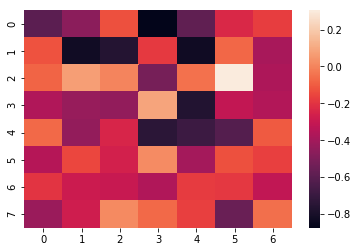

In [34]:
#f, axes = plt.subplots(2, 4, figsize=(18, 6))
tmp = np.sum(weight, axis=1)
df = pd.DataFrame(tmp)
sns.heatmap(df)

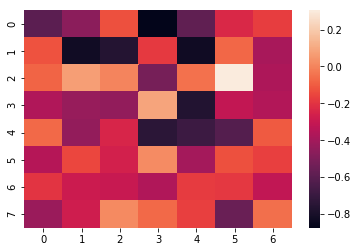

In [35]:
weight = model.conv1.weight.data.numpy().reshape(8, 7, 2)
df = pd.DataFrame(np.sum(weight, axis=2))
sns.heatmap(df)

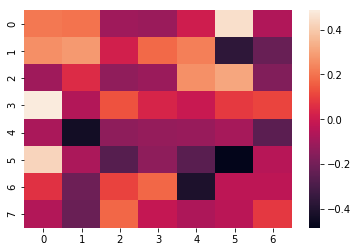

In [36]:
model = CNN(100)
weight = model.conv1.weight.data.numpy().reshape(8, 7, 2)
df = pd.DataFrame(np.sum(weight, axis=2))
sns.heatmap(df)

In [37]:
x = train(model, 20)

Epoch 01
tr_loss 1.897979 | tr_acc 59.77%
val_loss 0.587738 | val_acc 79.31%
Epoch 02
tr_loss 0.566860 | tr_acc 77.51%
val_loss 0.429480 | val_acc 82.64%
Epoch 03
tr_loss 0.469283 | tr_acc 81.96%
val_loss 0.425466 | val_acc 83.17%
Epoch 04
tr_loss 0.429807 | tr_acc 83.06%
val_loss 0.393207 | val_acc 83.49%
Epoch 05
tr_loss 0.402629 | tr_acc 83.62%
val_loss 0.365739 | val_acc 84.57%
Epoch 06
tr_loss 0.391199 | tr_acc 84.03%
val_loss 0.513866 | val_acc 77.60%
Epoch 07
tr_loss 0.398773 | tr_acc 84.13%
val_loss 0.358096 | val_acc 85.10%
Epoch 08
tr_loss 0.380208 | tr_acc 84.56%
val_loss 0.383876 | val_acc 82.96%
Epoch 09
tr_loss 0.379444 | tr_acc 84.13%
val_loss 0.372290 | val_acc 83.71%
Epoch 10
tr_loss 0.356329 | tr_acc 85.02%
val_loss 0.377378 | val_acc 83.82%
Epoch 11
tr_loss 0.371063 | tr_acc 84.72%
val_loss 0.400418 | val_acc 83.60%
Epoch 12
tr_loss 0.348417 | tr_acc 86.06%
val_loss 0.353960 | val_acc 85.74%
Epoch 13
tr_loss 0.347187 | tr_acc 85.90%
val_loss 0.419094 | val_acc 85.32%

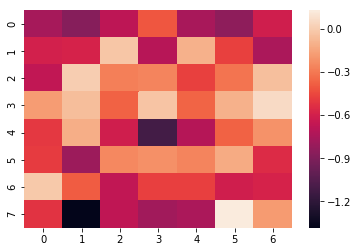

Epoch 01
tr_loss 1.084027 | tr_acc 65.13%
val_loss 0.513380 | val_acc 81.35%
Epoch 02
tr_loss 0.561683 | tr_acc 75.93%
val_loss 0.593489 | val_acc 68.81%
Epoch 03
tr_loss 0.488668 | tr_acc 77.83%
val_loss 0.468002 | val_acc 82.96%
Epoch 04
tr_loss 0.452677 | tr_acc 80.86%
val_loss 0.435129 | val_acc 80.81%
Epoch 05
tr_loss 0.459898 | tr_acc 81.59%
val_loss 0.383687 | val_acc 85.74%
Epoch 06
tr_loss 0.423125 | tr_acc 81.32%
val_loss 0.380012 | val_acc 84.24%
Epoch 07
tr_loss 0.421929 | tr_acc 82.61%
val_loss 0.456697 | val_acc 80.49%
Epoch 08
tr_loss 0.400791 | tr_acc 82.90%
val_loss 0.481027 | val_acc 79.64%
Epoch 09
tr_loss 0.399415 | tr_acc 83.01%
val_loss 0.408487 | val_acc 81.35%
Epoch 10
tr_loss 0.385539 | tr_acc 82.74%
val_loss 0.459531 | val_acc 79.10%
Epoch 11
tr_loss 0.384855 | tr_acc 84.21%
val_loss 0.394485 | val_acc 84.24%
Epoch 12
tr_loss 0.371485 | tr_acc 84.45%
val_loss 0.404963 | val_acc 85.10%
Epoch 13
tr_loss 0.401359 | tr_acc 83.06%
val_loss 0.360435 | val_acc 86.17%

tr_loss 0.505651 | tr_acc 78.72%
val_loss 0.423547 | val_acc 84.78%
Epoch 04
tr_loss 0.475519 | tr_acc 80.62%
val_loss 0.448083 | val_acc 82.74%
Epoch 05
tr_loss 0.455988 | tr_acc 81.27%
val_loss 0.507427 | val_acc 77.81%
Epoch 06
tr_loss 0.451035 | tr_acc 80.46%
val_loss 0.389287 | val_acc 85.74%
Epoch 07
tr_loss 0.441358 | tr_acc 81.99%
val_loss 0.394489 | val_acc 84.35%
Epoch 08
tr_loss 0.408554 | tr_acc 83.14%
val_loss 0.393841 | val_acc 84.99%
Epoch 09
tr_loss 0.398898 | tr_acc 83.25%
val_loss 0.414439 | val_acc 84.78%
Epoch 10
tr_loss 0.395253 | tr_acc 84.21%
val_loss 0.422845 | val_acc 82.53%
Epoch 11
tr_loss 0.375017 | tr_acc 85.23%
val_loss 0.464615 | val_acc 83.28%
Epoch 12
tr_loss 0.378605 | tr_acc 84.70%
val_loss 0.393285 | val_acc 85.21%
Epoch 13
tr_loss 0.372048 | tr_acc 84.96%
val_loss 0.386944 | val_acc 85.74%
Epoch 14
tr_loss 0.383002 | tr_acc 85.34%
val_loss 0.379260 | val_acc 85.74%
Epoch 15
tr_loss 0.376684 | tr_acc 85.15%
val_loss 0.367192 | val_acc 85.74%
Epoch 01

tr_loss 0.493108 | tr_acc 81.27%
val_loss 0.457134 | val_acc 83.49%
Epoch 06
tr_loss 0.448562 | tr_acc 82.87%
val_loss 0.501282 | val_acc 82.85%
Epoch 07
tr_loss 0.428269 | tr_acc 82.66%
val_loss 0.401327 | val_acc 86.07%
Epoch 08
tr_loss 0.403640 | tr_acc 83.95%
val_loss 0.367364 | val_acc 85.96%
Epoch 09
tr_loss 0.392423 | tr_acc 84.99%
val_loss 0.441777 | val_acc 84.46%
Epoch 10
tr_loss 0.378893 | tr_acc 84.37%
val_loss 0.364936 | val_acc 85.53%
Epoch 11
tr_loss 0.369626 | tr_acc 85.90%
val_loss 0.378239 | val_acc 85.64%
Epoch 12
tr_loss 0.371777 | tr_acc 85.23%
val_loss 0.434025 | val_acc 85.10%
Epoch 13
tr_loss 0.372892 | tr_acc 85.31%
val_loss 0.342974 | val_acc 85.32%
Epoch 14
tr_loss 0.365543 | tr_acc 84.96%
val_loss 0.350150 | val_acc 85.42%
Epoch 15
tr_loss 0.348434 | tr_acc 85.88%
val_loss 0.355911 | val_acc 86.07%
Epoch 01
tr_loss 1.096379 | tr_acc 58.00%
val_loss 0.588071 | val_acc 72.56%
Epoch 02
tr_loss 0.571983 | tr_acc 74.16%
val_loss 0.533019 | val_acc 74.17%
Epoch 03

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 01
tr_loss 0.994527 | tr_acc 51.51%
val_loss 0.703742 | val_acc 50.05%
Epoch 02
tr_loss 0.687634 | tr_acc 52.53%
val_loss 0.702422 | val_acc 54.34%
Epoch 03
tr_loss 0.692698 | tr_acc 57.68%
val_loss 0.672713 | val_acc 69.77%
Epoch 04
tr_loss 0.692741 | tr_acc 62.50%
val_loss 0.693570 | val_acc 55.63%
Epoch 05
tr_loss 0.662381 | tr_acc 64.19%
val_loss 0.672292 | val_acc 69.77%
Epoch 06
tr_loss 0.608583 | tr_acc 71.46%
val_loss 0.565184 | val_acc 77.17%
Epoch 07
tr_loss 0.510710 | tr_acc 76.87%
val_loss 0.477619 | val_acc 81.56%
Epoch 08
tr_loss 0.465466 | tr_acc 80.09%
val_loss 0.531747 | val_acc 78.24%
Epoch 09
tr_loss 0.446622 | tr_acc 80.17%
val_loss 0.614141 | val_acc 73.42%
Epoch 10
tr_loss 0.441180 | tr_acc 80.54%
val_loss 0.562513 | val_acc 78.78%
Epoch 11
tr_loss 0.431751 | tr_acc 81.75%
val_loss 0.446301 | val_acc 81.14%
Epoch 12
tr_loss 0.395323 | tr_acc 83.54%
val_loss 0.481671 | val_acc 78.24%
Epoch 13
tr_loss 0.402510 | tr_acc 83.03%
val_loss 0.441138 | val_acc 83.82%

tr_loss 0.548911 | tr_acc 77.81%
val_loss 0.504680 | val_acc 79.64%
Epoch 04
tr_loss 0.501375 | tr_acc 80.09%
val_loss 0.428587 | val_acc 81.67%
Epoch 05
tr_loss 0.442683 | tr_acc 82.55%
val_loss 0.503809 | val_acc 78.03%
Epoch 06
tr_loss 0.448506 | tr_acc 81.08%
val_loss 0.384518 | val_acc 83.49%
Epoch 07
tr_loss 0.425353 | tr_acc 82.71%
val_loss 0.427702 | val_acc 80.81%
Epoch 08
tr_loss 0.396410 | tr_acc 83.11%
val_loss 0.395081 | val_acc 83.60%
Epoch 09
tr_loss 0.410665 | tr_acc 83.68%
val_loss 0.380664 | val_acc 85.32%
Epoch 10
tr_loss 0.409556 | tr_acc 83.52%
val_loss 0.376404 | val_acc 84.14%
Epoch 11
tr_loss 0.393847 | tr_acc 83.49%
val_loss 0.367583 | val_acc 84.67%
Epoch 12
tr_loss 0.383735 | tr_acc 84.08%
val_loss 0.379927 | val_acc 83.92%
Epoch 13
tr_loss 0.388302 | tr_acc 84.51%
val_loss 0.440198 | val_acc 85.53%
Epoch 14
tr_loss 0.374338 | tr_acc 84.32%
val_loss 0.420323 | val_acc 80.71%
Epoch 15
tr_loss 0.361959 | tr_acc 84.59%
val_loss 0.385718 | val_acc 83.49%
Epoch 01

tr_loss 0.429432 | tr_acc 82.69%
val_loss 0.381589 | val_acc 84.78%
Epoch 06
tr_loss 0.385640 | tr_acc 84.32%
val_loss 0.369004 | val_acc 85.64%
Epoch 07
tr_loss 0.389617 | tr_acc 83.84%
val_loss 0.383662 | val_acc 84.99%
Epoch 08
tr_loss 0.386180 | tr_acc 84.53%
val_loss 0.363821 | val_acc 84.67%
Epoch 09
tr_loss 0.370676 | tr_acc 84.94%
val_loss 0.621549 | val_acc 70.42%
Epoch 10
tr_loss 0.383656 | tr_acc 84.70%
val_loss 0.401224 | val_acc 84.67%
Epoch 11
tr_loss 0.372629 | tr_acc 84.43%
val_loss 0.403078 | val_acc 85.32%
Epoch 12
tr_loss 0.363542 | tr_acc 85.10%
val_loss 0.408818 | val_acc 82.96%
Epoch 13
tr_loss 0.361927 | tr_acc 84.88%
val_loss 0.415299 | val_acc 82.42%
Epoch 14
tr_loss 0.362488 | tr_acc 85.31%
val_loss 0.394198 | val_acc 81.56%
Epoch 15
tr_loss 0.374236 | tr_acc 84.94%
val_loss 0.362204 | val_acc 85.64%
Epoch 01
tr_loss 1.398271 | tr_acc 72.31%
val_loss 0.520038 | val_acc 81.14%
Epoch 02
tr_loss 0.479668 | tr_acc 79.68%
val_loss 0.424381 | val_acc 85.10%
Epoch 03

tr_loss 0.418132 | tr_acc 81.88%
val_loss 0.515010 | val_acc 75.99%
Epoch 07
tr_loss 0.390282 | tr_acc 83.89%
val_loss 0.418133 | val_acc 82.10%
Epoch 08
tr_loss 0.391756 | tr_acc 83.52%
val_loss 0.392908 | val_acc 81.67%
Epoch 09
tr_loss 0.394890 | tr_acc 83.01%
val_loss 0.383268 | val_acc 85.96%
Epoch 10
tr_loss 0.363613 | tr_acc 85.37%
val_loss 0.357670 | val_acc 85.85%
Epoch 11
tr_loss 0.345829 | tr_acc 85.77%
val_loss 0.363102 | val_acc 85.53%
Epoch 12
tr_loss 0.351453 | tr_acc 85.47%
val_loss 0.392013 | val_acc 86.07%
Epoch 13
tr_loss 0.362149 | tr_acc 85.04%
val_loss 0.466537 | val_acc 83.92%
Epoch 14
tr_loss 0.341143 | tr_acc 85.29%
val_loss 0.438463 | val_acc 84.03%
Epoch 15
tr_loss 0.350054 | tr_acc 85.37%
val_loss 0.403383 | val_acc 82.74%
Epoch 01
tr_loss 1.641241 | tr_acc 61.73%
val_loss 0.562692 | val_acc 74.49%
Epoch 02
tr_loss 0.507304 | tr_acc 78.37%
val_loss 0.420310 | val_acc 83.17%
Epoch 03
tr_loss 0.439084 | tr_acc 82.42%
val_loss 0.380219 | val_acc 84.89%
Epoch 04

tr_loss 0.416336 | tr_acc 82.20%
val_loss 0.452300 | val_acc 83.07%
Epoch 09
tr_loss 0.419386 | tr_acc 82.23%
val_loss 0.480760 | val_acc 83.28%
Epoch 10
tr_loss 0.397253 | tr_acc 83.41%
val_loss 0.517598 | val_acc 75.67%
Epoch 11
tr_loss 0.410113 | tr_acc 82.12%
val_loss 0.424838 | val_acc 84.46%
Epoch 12
tr_loss 0.392581 | tr_acc 83.54%
val_loss 0.446957 | val_acc 82.42%
Epoch 13
tr_loss 0.386216 | tr_acc 83.92%
val_loss 0.429383 | val_acc 84.67%
Epoch 14
tr_loss 0.372968 | tr_acc 83.95%
val_loss 0.409253 | val_acc 82.85%
Epoch 15
tr_loss 0.369048 | tr_acc 84.21%
val_loss 0.661881 | val_acc 72.03%


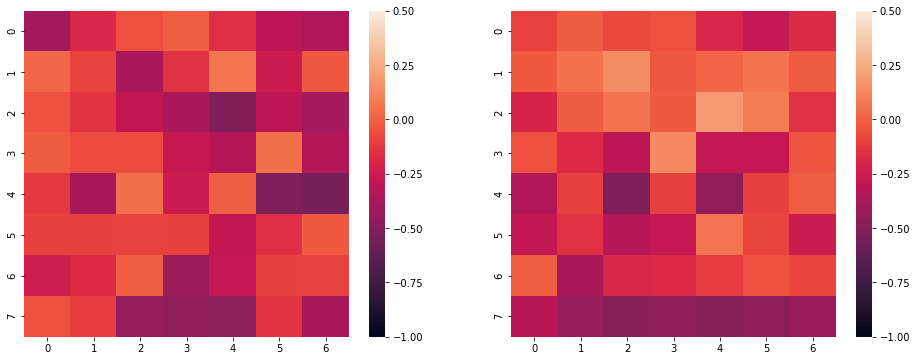

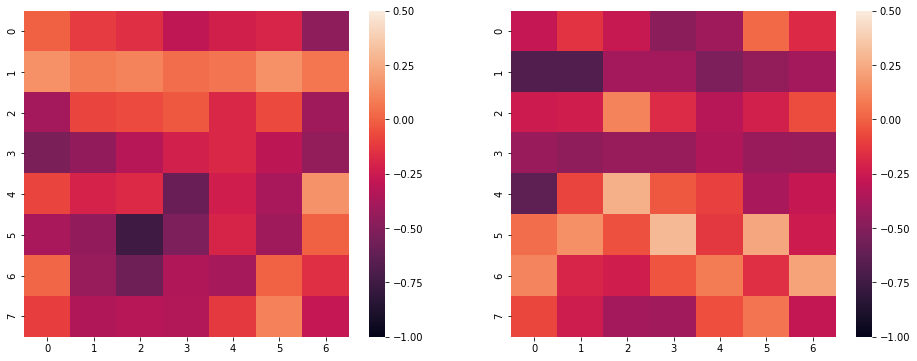

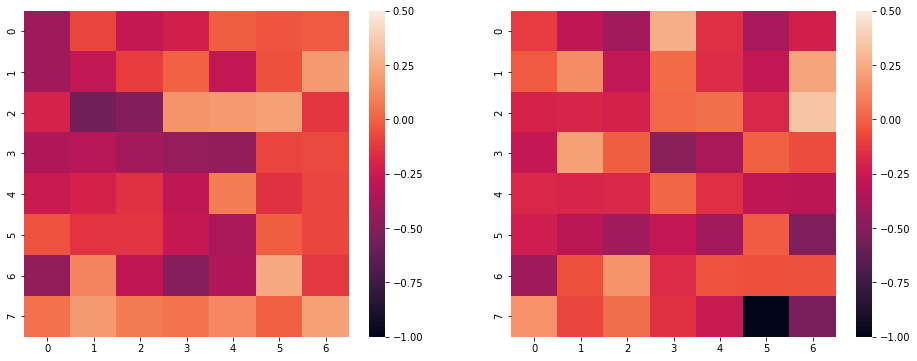

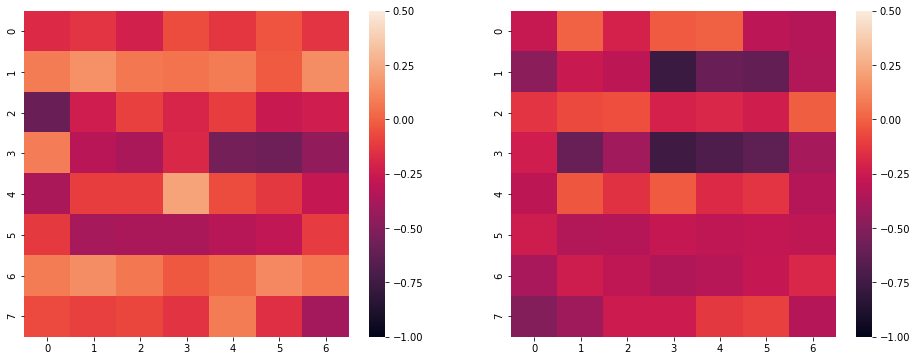

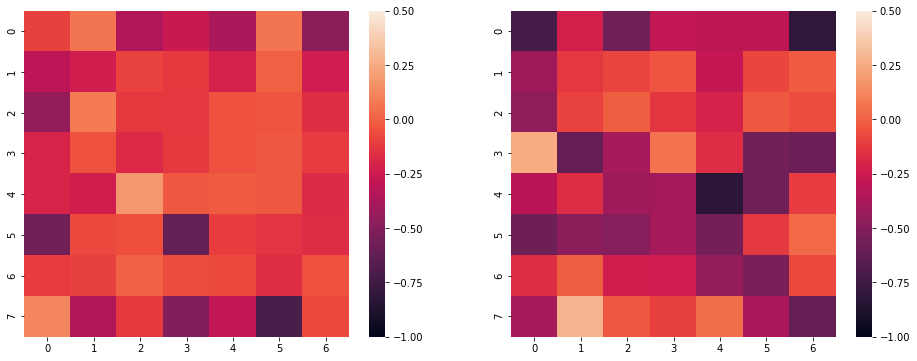

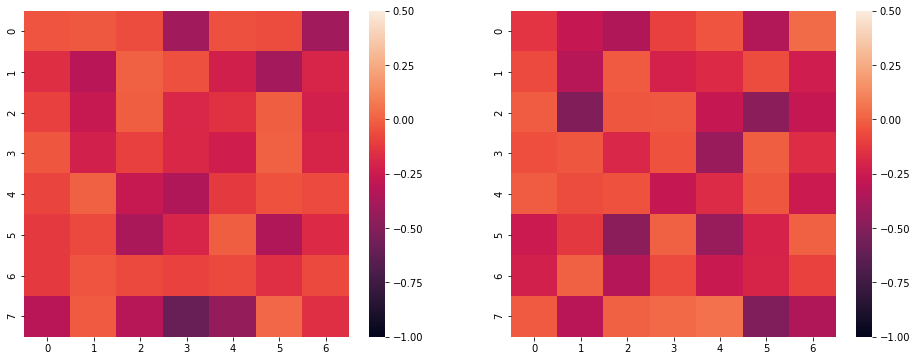

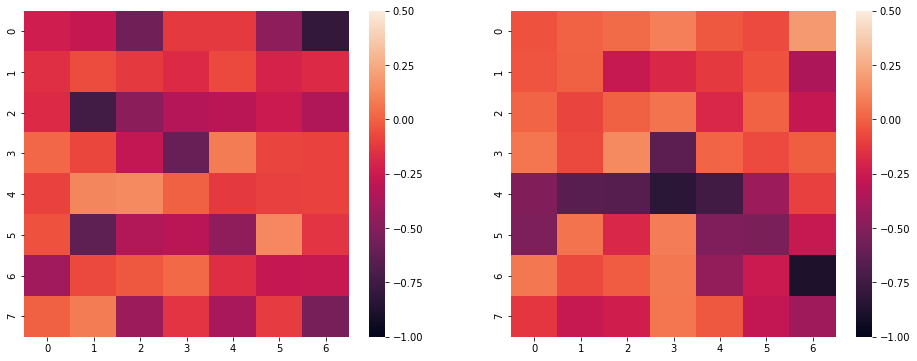

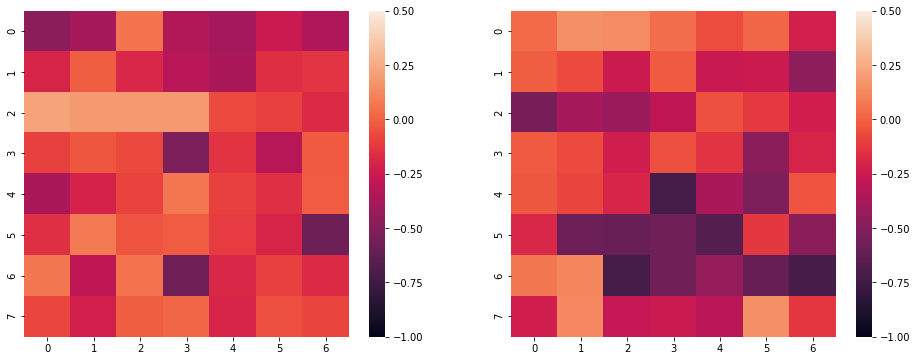

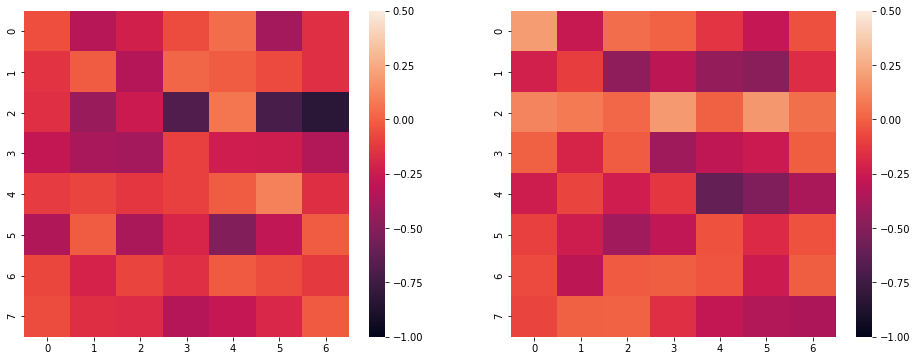

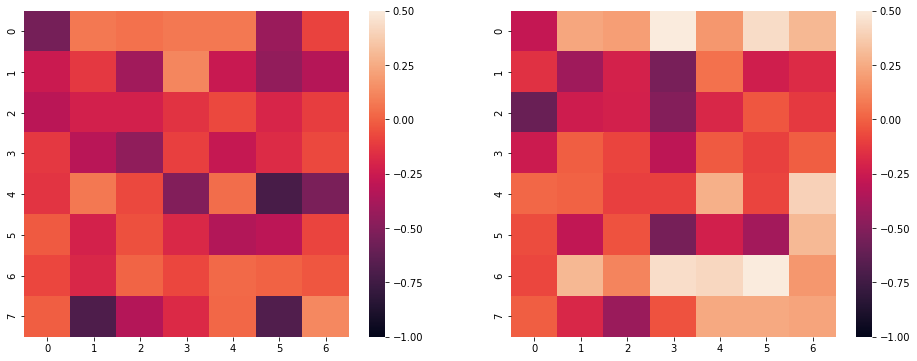

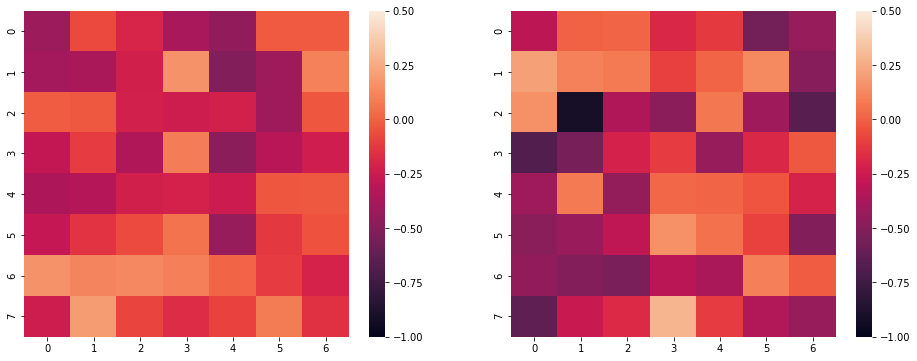

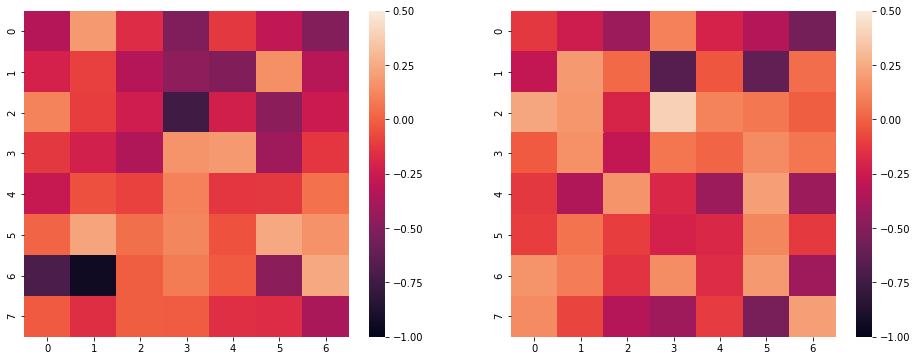

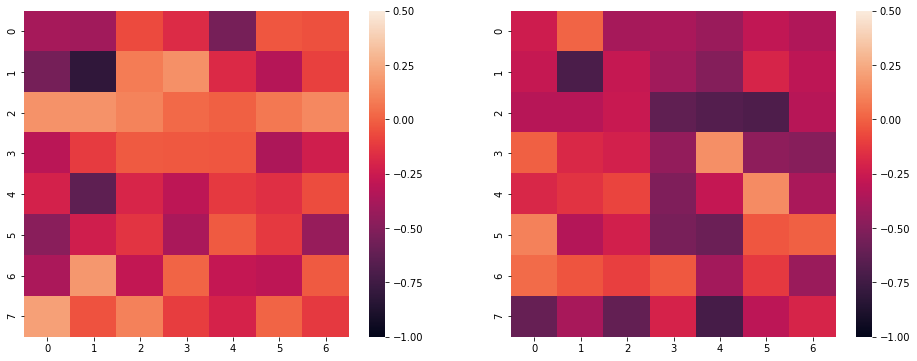

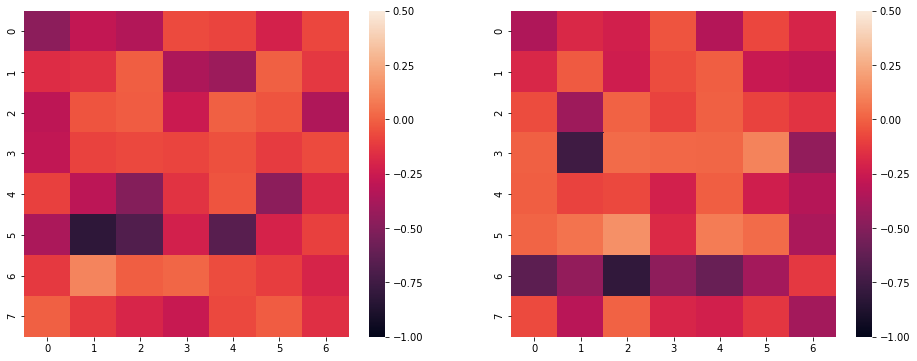

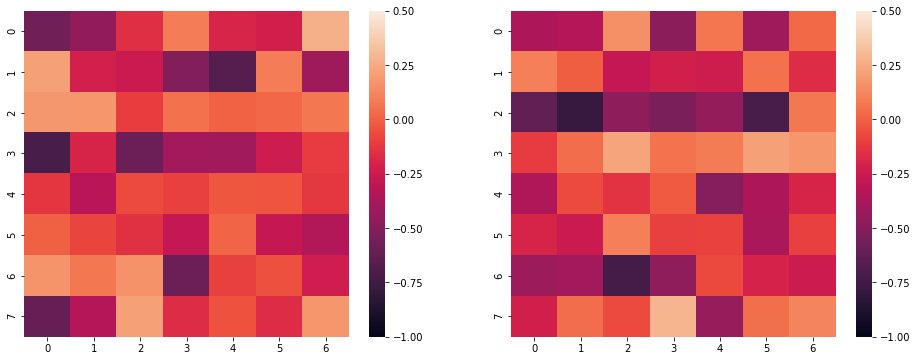

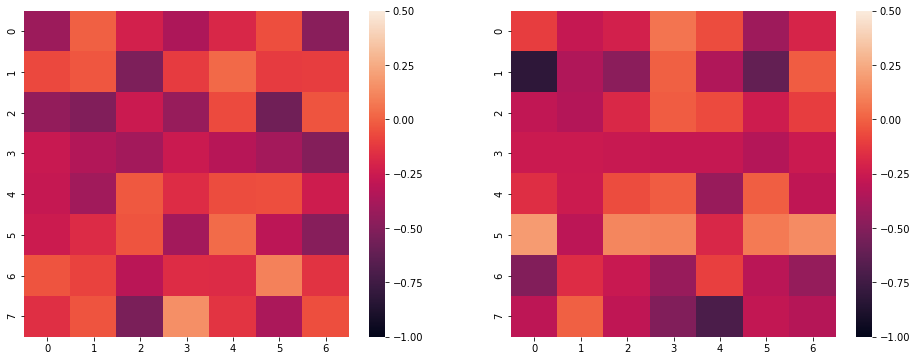

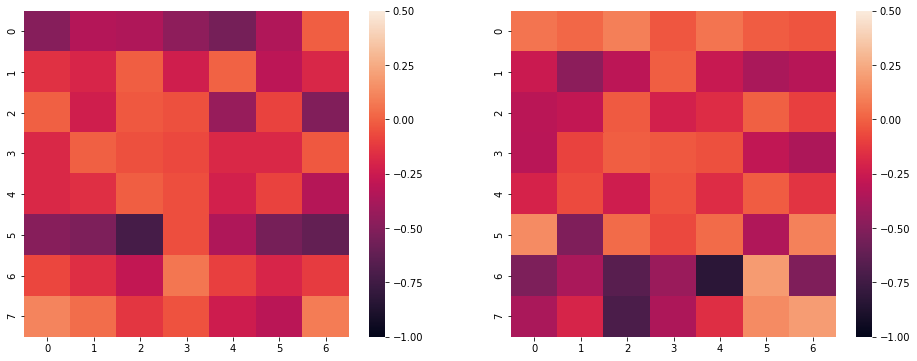

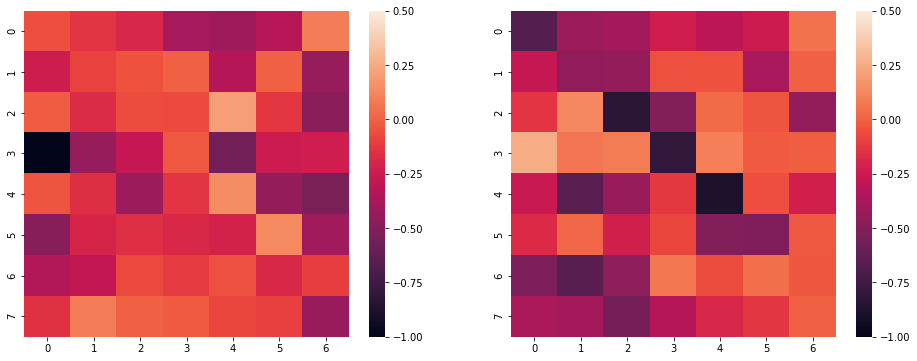

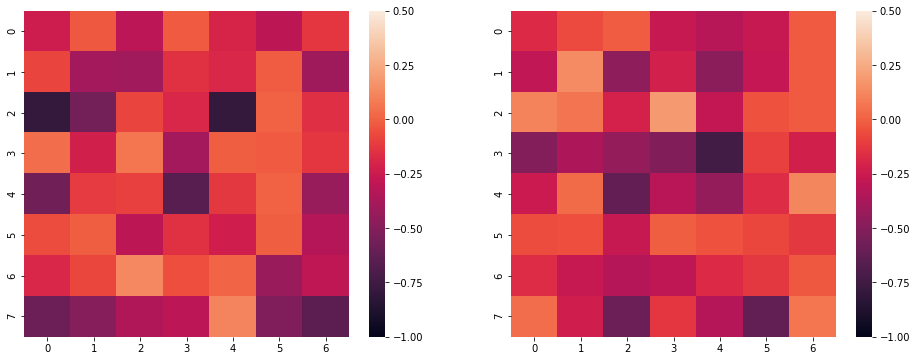

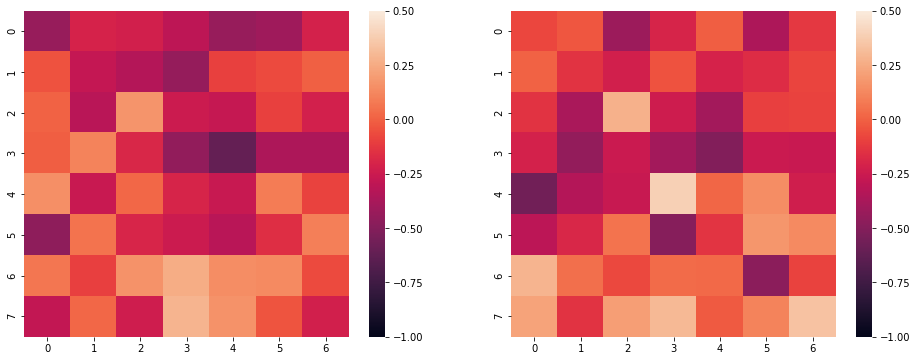

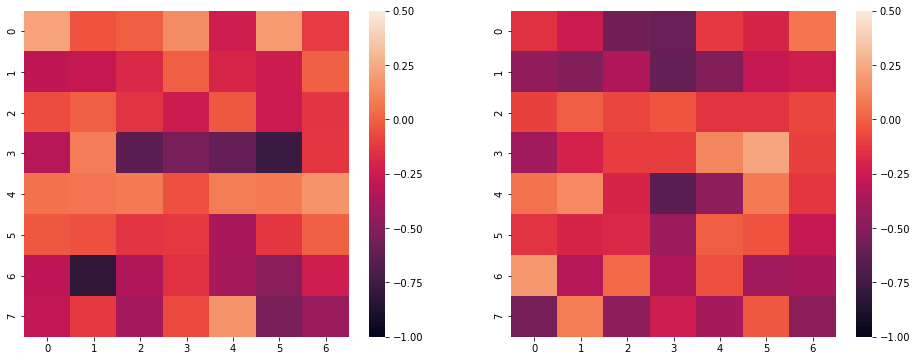

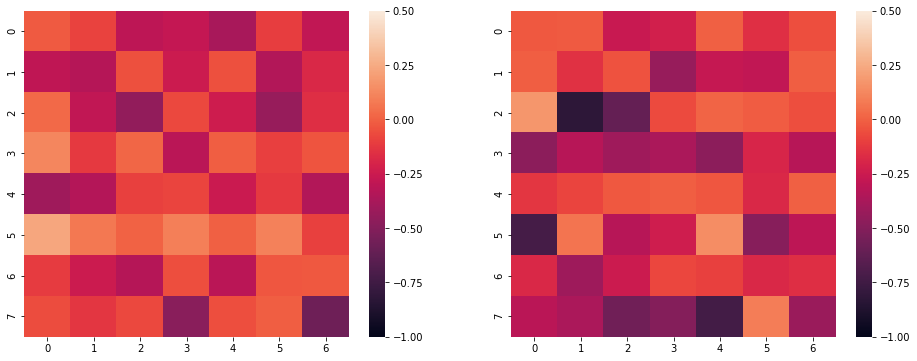

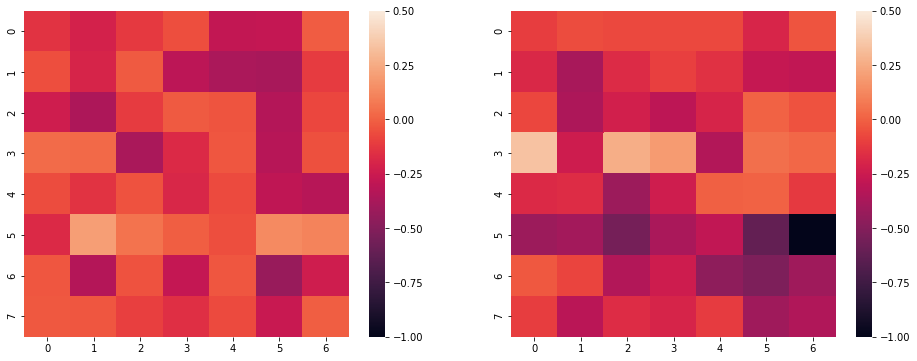

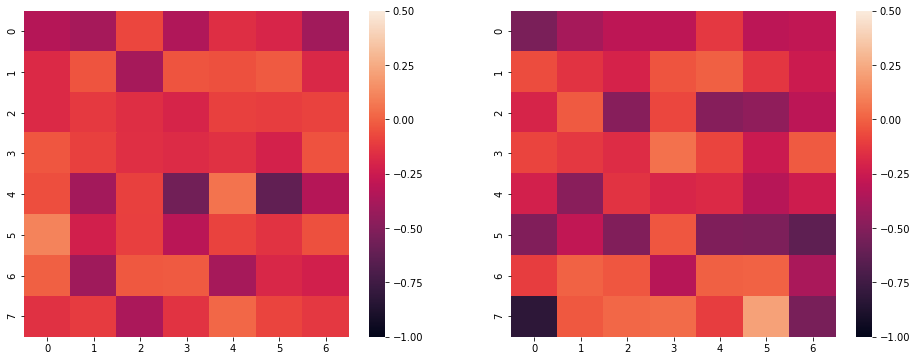

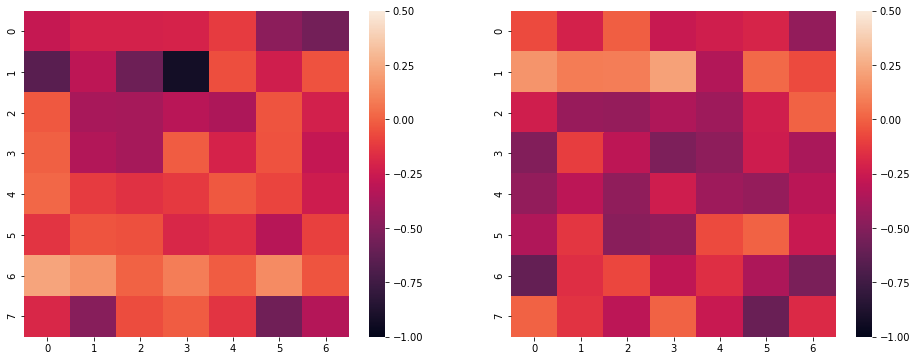

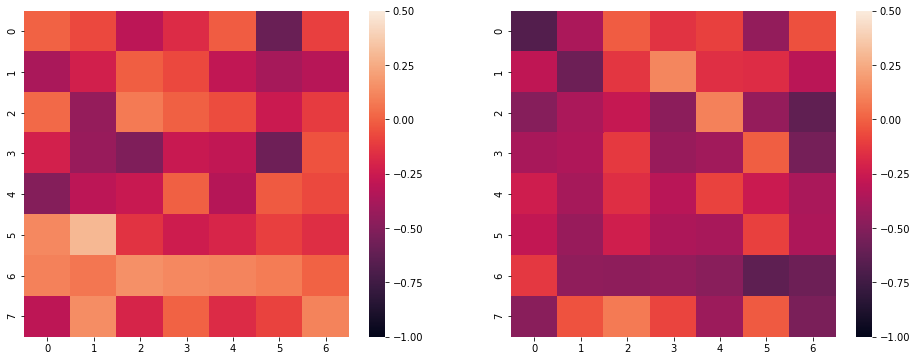

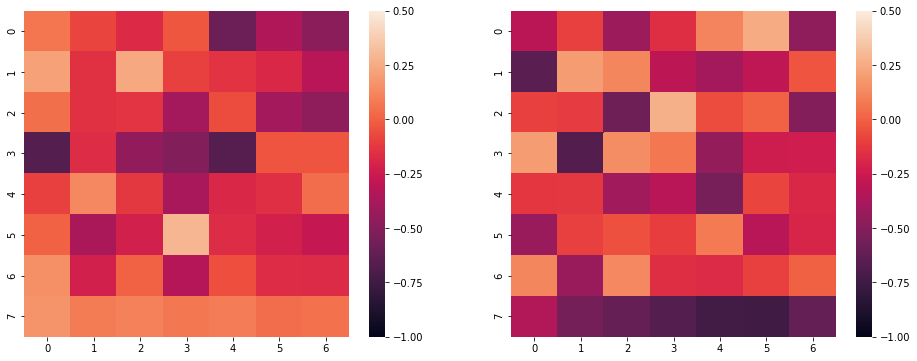

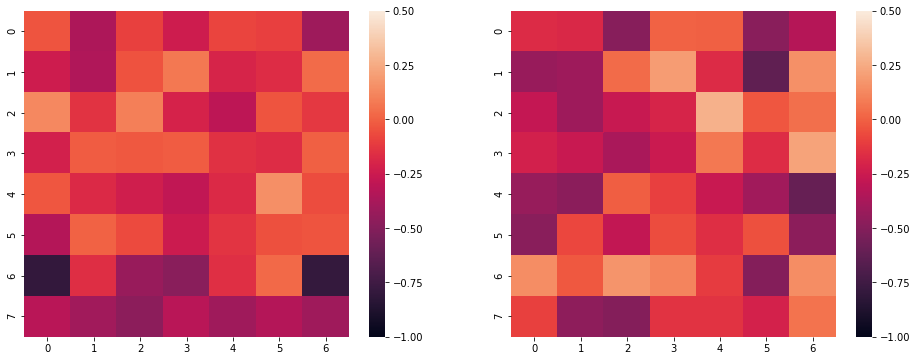

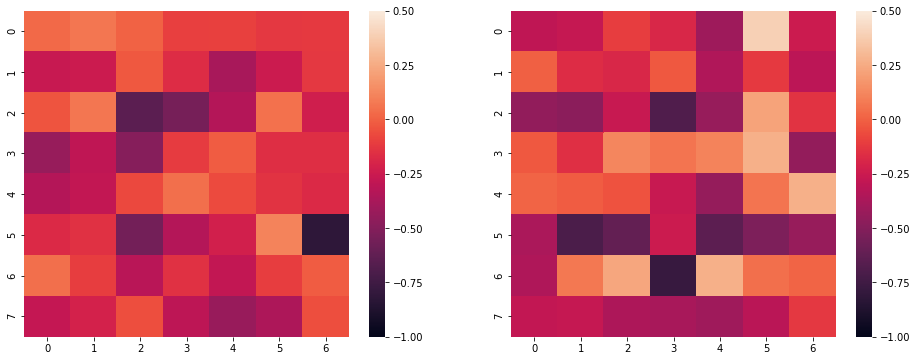

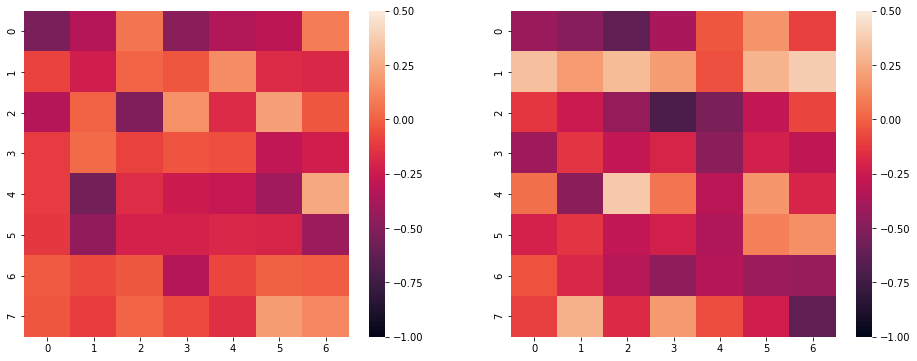

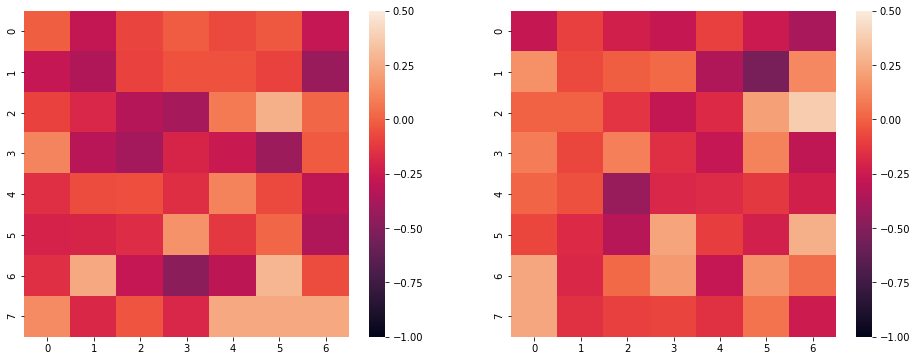

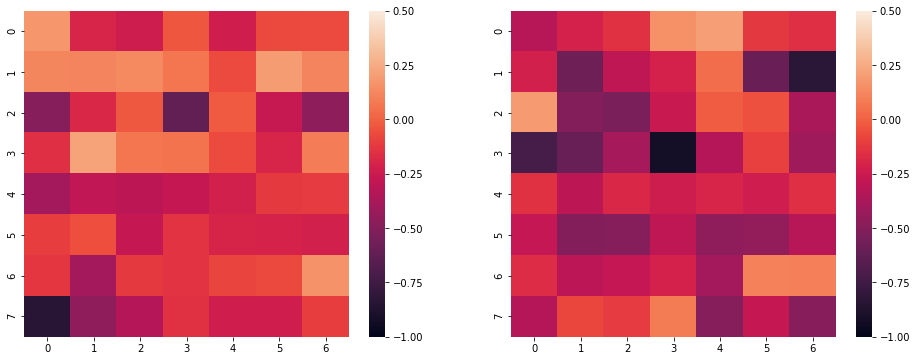

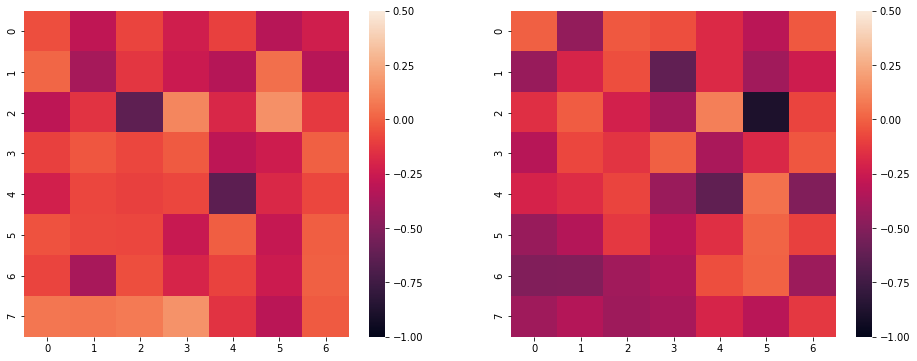

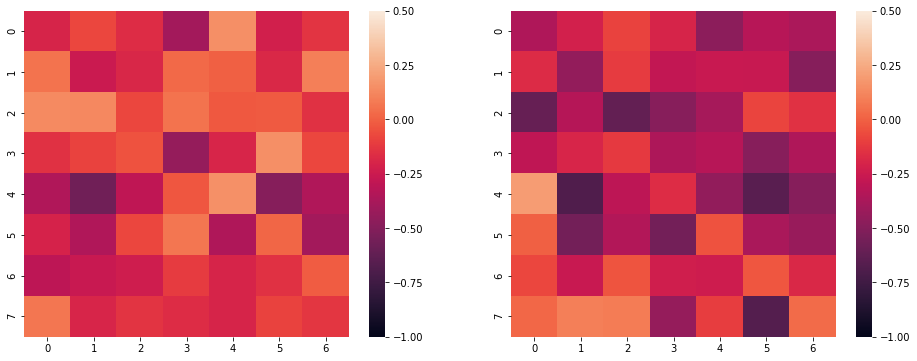

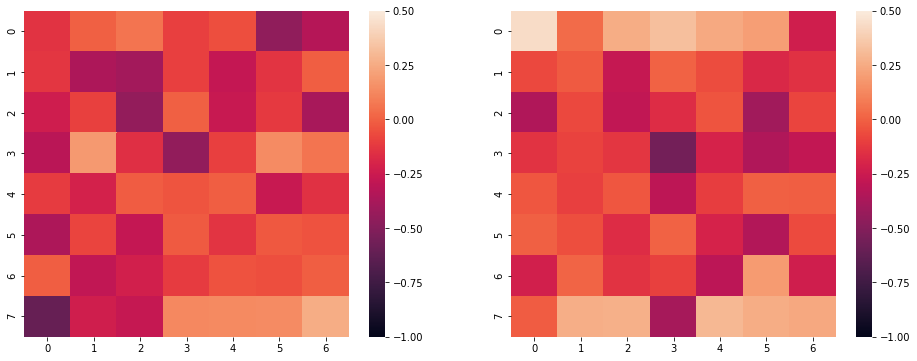

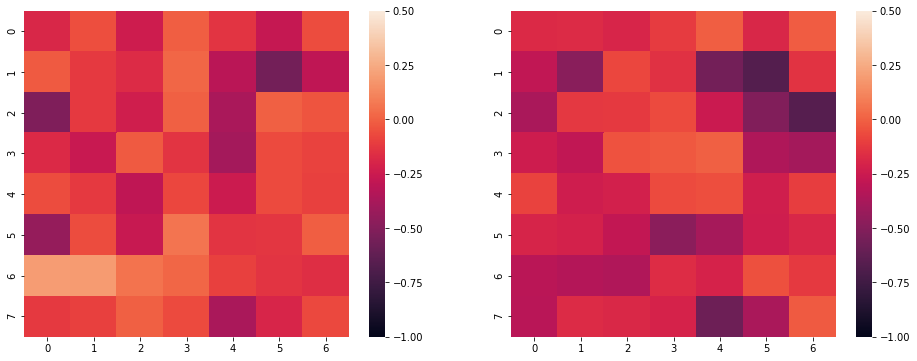

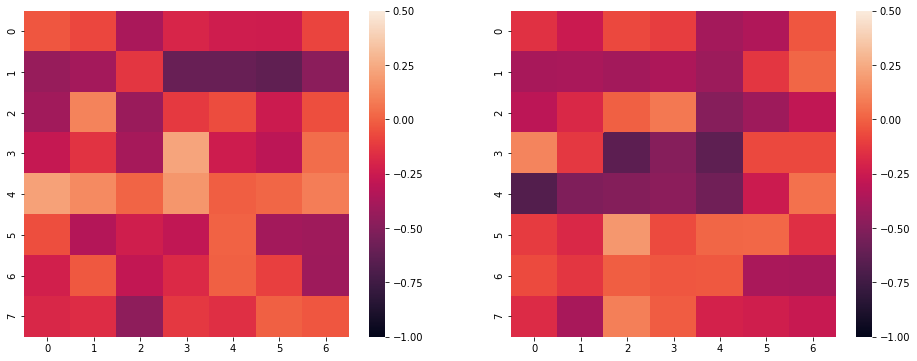

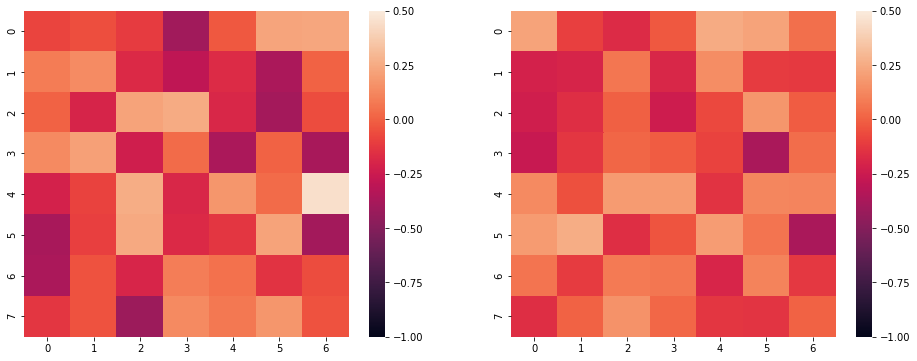

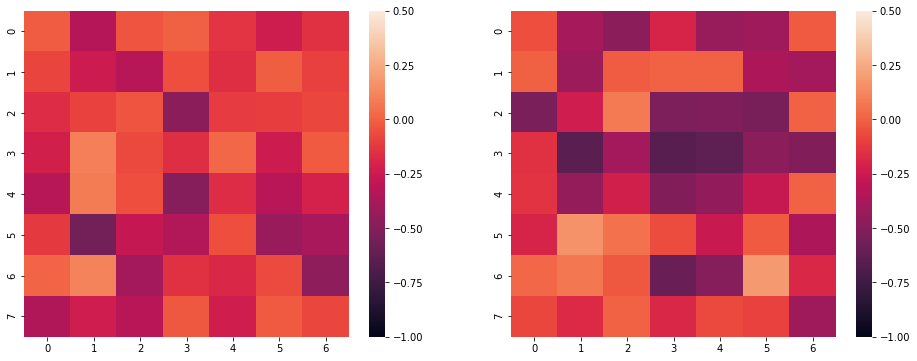

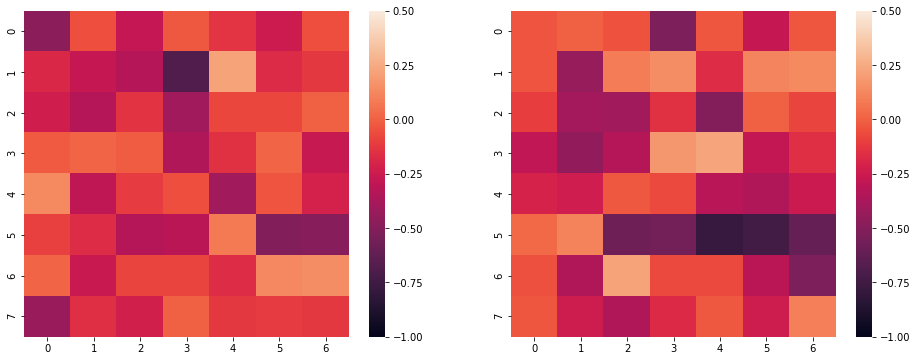

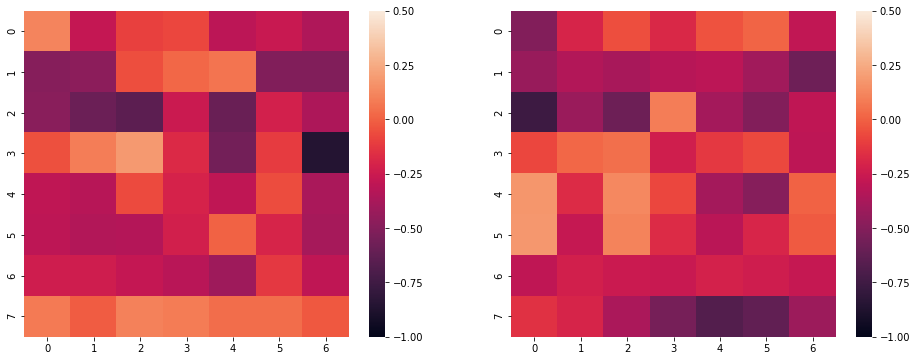

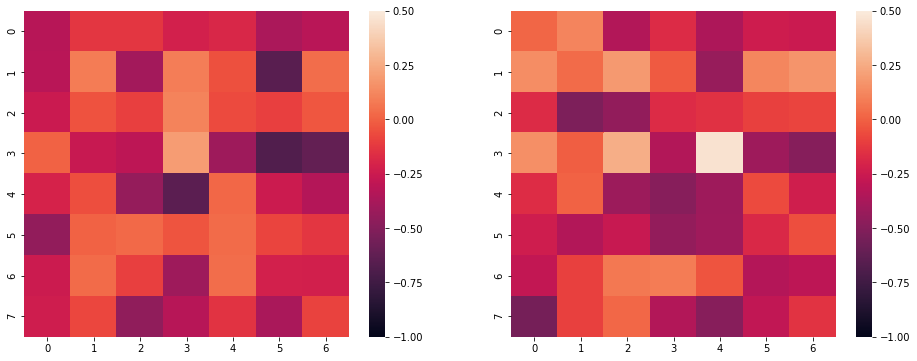

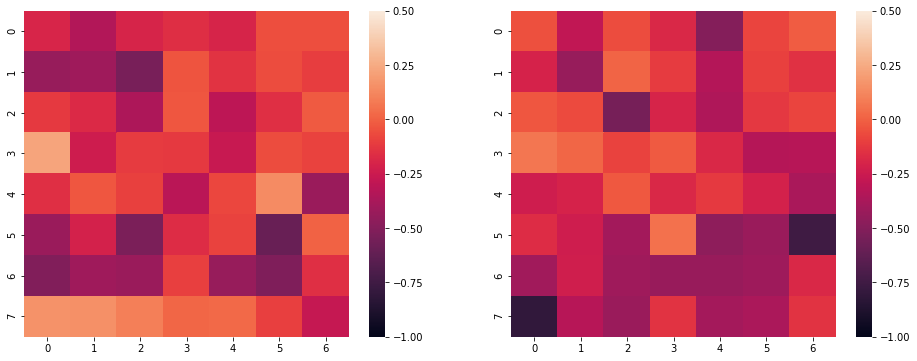

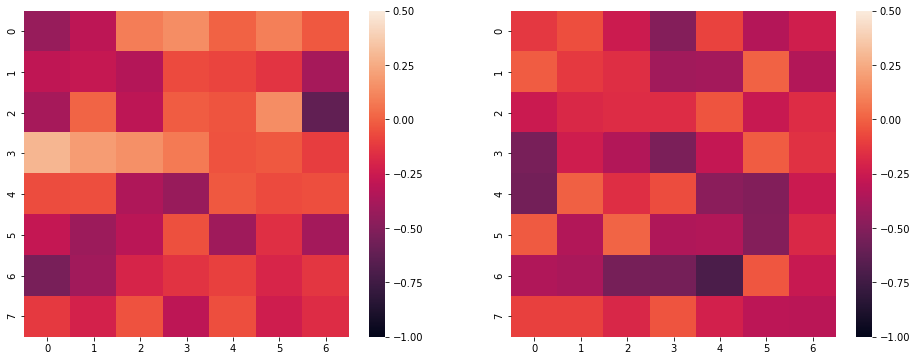

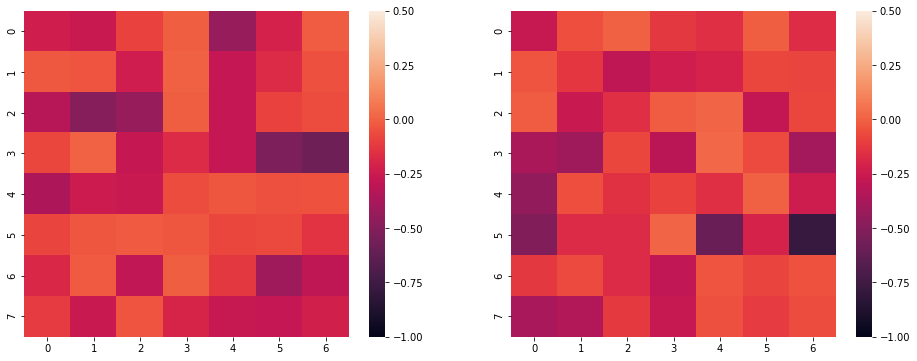

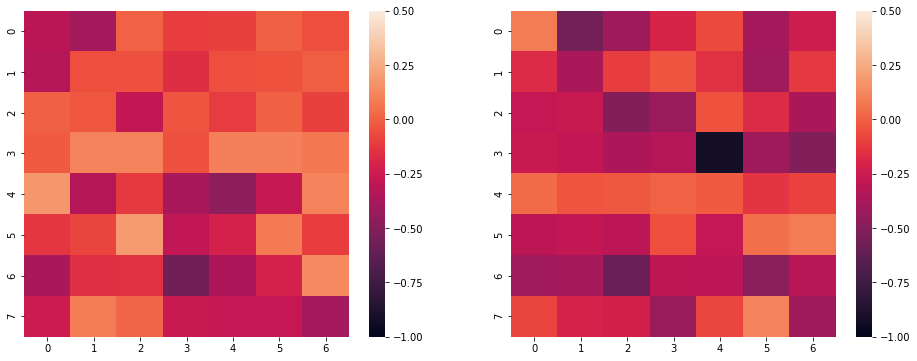

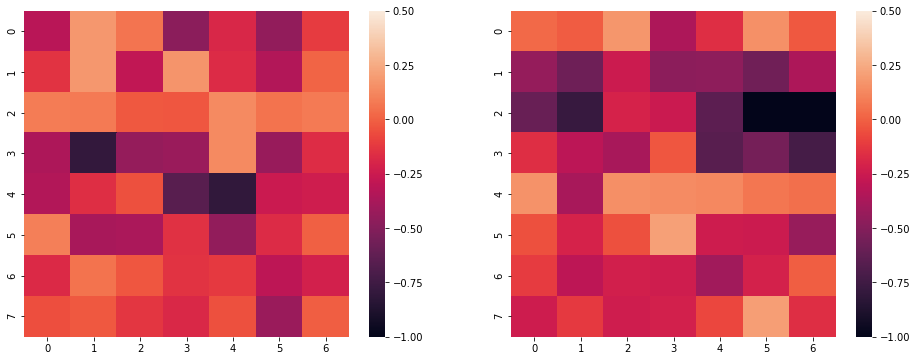

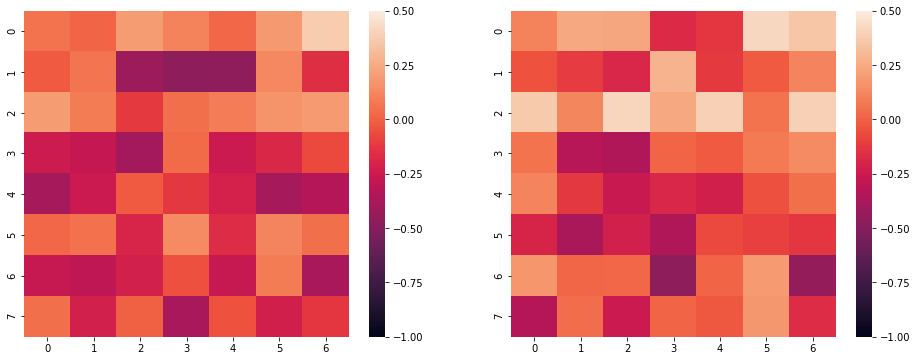

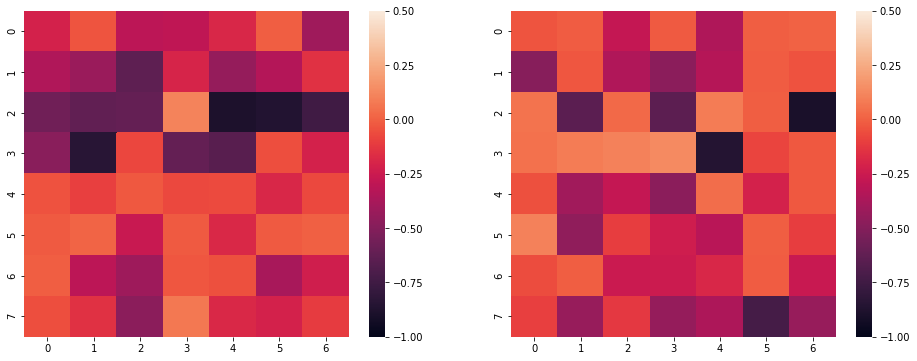

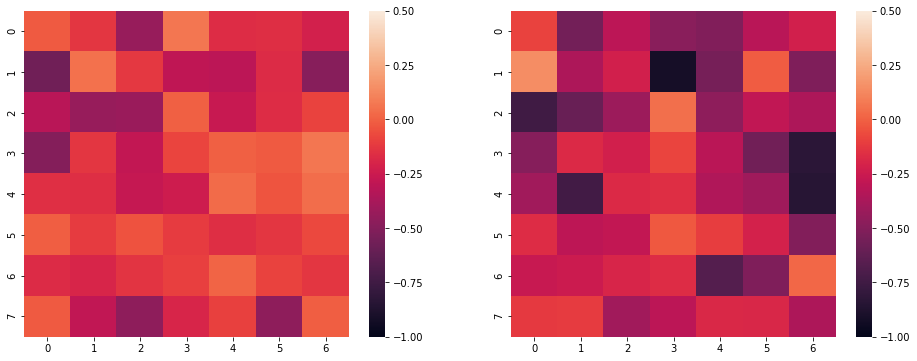

In [55]:
for i in range(50): 
    model = CNN(100)
    x = train(model, 15)
    weight = model.conv1.weight.data.numpy().reshape(8, 7, 2)
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(pd.DataFrame(weight[:,:,0]), vmax=0.5, vmin=-1, ax=ax[0])
    sns.heatmap(pd.DataFrame(weight[:,:,1]), vmax=0.5, vmin=-1, ax=ax[1])           
    plt.savefig(f'heatmap/{i}.png', dpi=200)